### **Wikipedia Image Captioning with CLIP & BLIP**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deekshitthvegi","key":"abec15f9d7106d9d6fa2577e4695b5b0"}'}

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)

In [ ]:
!cp kaggle.json /root/.kaggle/

In [ ]:
os.chmod('/root/.kaggle/kaggle.json', 600)

In [ ]:
!kaggle competitions download -c wikipedia-image-caption -f train-00000-of-00005.tsv

100% 5.04G/5.04G [01:15<00:00, 65.4MB/s]
100% 5.04G/5.04G [01:15<00:00, 71.9MB/s]


In [ ]:
!unzip train-00000-of-00005.tsv.zip

Archive:  train-00000-of-00005.tsv.zip
  inflating: train-00000-of-00005.tsv  


In [ ]:
!rm train-00000-of-00005.tsv.zip

In [ ]:
import pandas as pd
import numpy as np
import os

data_path = 'train-00000-of-00005.tsv'
data = pd.read_csv(data_path, sep='\t', nrows=100000)

data.head()

,language,page_url,image_url,page_title,section_title,hierarchical_section_title,caption_reference_description,caption_attribution_description,caption_alt_text_description,mime_type,original_height,original_width,is_main_image,attribution_passes_lang_id,page_changed_recently,context_page_description,context_section_description,caption_title_and_reference_description
0,fr,https://fr.wikipedia.org/wiki/Pariser_Kanonen,https://upload.wikimedia.org/wikipedia/commons...,Pariser Kanonen,Bilan,Pariser Kanonen / Bilan,NaN,Français&#160;: Plaque apposée au n° 81 du bou...,NaN,image/jpeg,1279,1812,False,True,True,Les Pariser Kanonen sont sept pièces d’artille...,Le ou les canons restants sont démontés devant...,Pariser Kanonen [SEP]
1,tg,https://tg.wikipedia.org/wiki/Republic_P-43_La...,http://upload.wikimedia.org/wikipedia/commons/...,Republic P-43 Lancer,NaN,Republic P-43 Lancer,NaN,A Republic P-43 Lancer in flight over Esler Fi...,NaN,image/jpeg,306,591,True,False,False,Republic P-43 Lancer — як ҳавогарди сохтаи Rep...,Republic P-43 Lancer (англ. Republic P-43 Lanc...,Republic P-43 Lancer [SEP]
2,en,"https://en.wikipedia.org/wiki/Deer_Park,_Wisco...",https://upload.wikimedia.org/wikipedia/commons...,"Deer Park, Wisconsin",NaN,"Deer Park, Wisconsin",Downtown Deer Park,"English: Downtown Deer Park, Wisconsin on WIS46.",Downtown Deer Park,image/jpeg,1824,2736,True,True,True,"Deer Park is a village in St. Croix County, Wi...","Deer Park is a village in St. Croix County, Wi...","Deer Park, Wisconsin [SEP] Downtown Deer Park"
3,pt,https://pt.wikipedia.org/wiki/Vaux-l%C3%A8s-Mo...,https://upload.wikimedia.org/wikipedia/commons...,Vaux-lès-Mouzon,NaN,Vaux-lès-Mouzon,NaN,Français&#160;: Vaux-lès-Mouzon&#160;: le village,NaN,image/jpeg,1704,2272,True,False,False,Vaux-lès-Mouzon é uma comuna francesa na regiã...,Vaux-lès-Mouzon é uma comuna francesa na regiã...,Vaux-lès-Mouzon [SEP]
4,ne,https://ne.wikipedia.org/wiki/%E0%A4%95%E0%A5%...,https://upload.wikimedia.org/wikipedia/commons...,क्रिसमस टापु,NaN,क्रिसमस टापु,NaN,This is a locator map for Christmas Island I m...,NaN,image/png,165,248,True,False,False,क्रिसमस टापु हिन्द महासागरमा अवस्थित अष्ट्रेलि...,क्रिसमस टापु हिन्द महासागरमा अवस्थित अष्ट्रेलि...,क्रिसमस टापु [SEP]


### **Data Cleaning & Preprocessing**

In [ ]:
data = data[data['language'] == 'en']
print(data.head())

   language                                           page_url  \
2        en  https://en.wikipedia.org/wiki/Deer_Park,_Wisco...   
5        en    https://en.wikipedia.org/wiki/J%C3%BCrgen_Ovens   
11       en            https://en.wikipedia.org/wiki/MV_Agusta   
16       en    https://en.wikipedia.org/wiki/Wolfe_City,_Texas   
23       en  https://simple.wikipedia.org/wiki/The_Flintstones   

                                            image_url            page_title  \
2   https://upload.wikimedia.org/wikipedia/commons...  Deer Park, Wisconsin   
5   https://upload.wikimedia.org/wikipedia/commons...          Jürgen Ovens   
11  https://upload.wikimedia.org/wikipedia/commons...             MV Agusta   
16  https://upload.wikimedia.org/wikipedia/commons...     Wolfe City, Texas   
23  https://upload.wikimedia.org/wikipedia/commons...       The Flintstones   

                      section_title  \
2                               NaN   
5                             Works   
11  1945—19

In [ ]:
data = data[['image_url', 'caption_title_and_reference_description']]
data.dropna(subset=['image_url', 'caption_title_and_reference_description'], inplace=True)

import re

def clean_caption(caption):
    caption = re.sub(r'\[.*?\]', '', caption)
    caption = re.sub(r'[^a-zA-Z0-9\s]', '', caption)
    caption = re.sub(r'\s+', ' ', caption).strip()
    return caption

data['cleaned_caption'] = data['caption_title_and_reference_description'].apply(clean_caption)

print(data.head())

                                           image_url  \
0  https://upload.wikimedia.org/wikipedia/commons...   
1  https://upload.wikimedia.org/wikipedia/commons...   
2  https://upload.wikimedia.org/wikipedia/commons...   
3  https://upload.wikimedia.org/wikipedia/commons...   
4  https://upload.wikimedia.org/wikipedia/commons...   

             caption_title_and_reference_description  \
0      Deer Park, Wisconsin [SEP] Downtown Deer Park   
1  Jürgen Ovens [SEP] Jürgen Ovens's Justitia, 16...   
2            MV Agusta [SEP] 1956 MV Agusta 250 Raid   
3                           Wolfe City, Texas [SEP]    
4       The Flintstones [SEP] Seth MacFarlane's logo   

                                     cleaned_caption  
0             Deer Park Wisconsin Downtown Deer Park  
1  Jrgen Ovens Jrgen Ovenss Justitia 16631665 Mus...  
2                  MV Agusta 1956 MV Agusta 250 Raid  
3                                   Wolfe City Texas  
4              The Flintstones Seth MacFarlanes log

<ipython-input-89-66f87f85dc20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['image_url', 'caption_title_and_reference_description'], inplace=True)


In [ ]:
print("Missing values:\n", data.isnull().sum())
print(data.head())

data.to_csv('cleaned_wikipedia_image_captions.csv', index=False)
from google.colab import files
files.download('cleaned_wikipedia_image_captions.csv')

Missing values:
 image_url                                  0
caption_title_and_reference_description    0
cleaned_caption                            0
dtype: int64
                                           image_url  \
0  https://upload.wikimedia.org/wikipedia/commons...   
1  https://upload.wikimedia.org/wikipedia/commons...   
2  https://upload.wikimedia.org/wikipedia/commons...   
3  https://upload.wikimedia.org/wikipedia/commons...   
4  https://upload.wikimedia.org/wikipedia/commons...   

             caption_title_and_reference_description  \
0      Deer Park, Wisconsin [SEP] Downtown Deer Park   
1  Jürgen Ovens [SEP] Jürgen Ovens's Justitia, 16...   
2            MV Agusta [SEP] 1956 MV Agusta 250 Raid   
3                           Wolfe City, Texas [SEP]    
4       The Flintstones [SEP] Seth MacFarlane's logo   

                                     cleaned_caption  
0             Deer Park Wisconsin Downtown Deer Park  
1  Jrgen Ovens Jrgen Ovenss Justitia 16631665 Mus..

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

data_path = 'cleaned_wikipedia_image_captions.csv'
data = pd.read_csv(data_path)

print(data.head())

                                           image_url  \
0  https://upload.wikimedia.org/wikipedia/commons...   
1  https://upload.wikimedia.org/wikipedia/commons...   
2  https://upload.wikimedia.org/wikipedia/commons...   
3  https://upload.wikimedia.org/wikipedia/commons...   
4  https://upload.wikimedia.org/wikipedia/commons...   

             caption_title_and_reference_description  \
0      Deer Park, Wisconsin [SEP] Downtown Deer Park   
1  Jürgen Ovens [SEP] Jürgen Ovens's Justitia, 16...   
2            MV Agusta [SEP] 1956 MV Agusta 250 Raid   
3                           Wolfe City, Texas [SEP]    
4       The Flintstones [SEP] Seth MacFarlane's logo   

                                     cleaned_caption  
0             Deer Park Wisconsin Downtown Deer Park  
1  Jrgen Ovens Jrgen Ovenss Justitia 16631665 Mus...  
2                  MV Agusta 1956 MV Agusta 250 Raid  
3                                   Wolfe City Texas  
4              The Flintstones Seth MacFarlanes log

### **Downloading images from the URL's**

In [ ]:
import os
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import pandas as pd
import time
import numpy as np

In [ ]:
os.makedirs('images', exist_ok=True)

headers = {
    'User-Agent': 'WikipediaImageDownloader/1.0 ()' #change this to use ur agent
}

def download_and_process_image(url, size=(224, 224), output_dir='images', img_count=None):
    """
    Downloads an image from the URL, resizes it, and saves it.
    Skips if the image is invalid or the download fails.
    """
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize(size)

        os.makedirs(output_dir, exist_ok=True)
        image_path = os.path.join(output_dir, f"image_{img_count}.jpg")
        img.save(image_path)
        return image_path  # Return the saved image path

    except requests.exceptions.RequestException as e:
        print(f"HTTP Error: Could not download {url} | Error: {e}")
        return None
    except UnidentifiedImageError as e:
        print(f"Image Error: Could not process {url} | Error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected Error: {url} | Error: {e}")
        return None

data_path = 'cleaned_wikipedia_image_captions.csv'
data = pd.read_csv(data_path)

# Download images
start_time = time.time()
downloaded_images = []

for idx, row in data.iterrows():
    image_url = row['image_url']
    print(f"Processing image {idx + 1} of {len(data)}...")
    image_path = download_and_process_image(image_url, img_count=idx + 1)
    downloaded_images.append(image_path)

data['image_path'] = downloaded_images

data.to_csv('images_with_paths.csv', index=False)

end_time = time.time()
print(f"Total images successfully downloaded: {sum(path is not None for path in downloaded_images)}")
print(f"Total time taken: {(end_time - start_time) / 60:.2f} minutes")

Processing image 1 of 14670...
Processing image 2 of 14670...
Processing image 3 of 14670...
Processing image 4 of 14670...
Processing image 5 of 14670...
Processing image 6 of 14670...
Processing image 7 of 14670...
Processing image 8 of 14670...
Image Error: Could not process https://upload.wikimedia.org/wikipedia/commons/e/e9/Near-stars-past-future-en.svg | Error: cannot identify image file <_io.BytesIO object at 0x7c0f98456a20>
Processing image 9 of 14670...
Processing image 10 of 14670...
Processing image 11 of 14670...
Processing image 12 of 14670...
Processing image 13 of 14670...
Processing image 14 of 14670...
Processing image 15 of 14670...
Processing image 16 of 14670...
Processing image 17 of 14670...
Processing image 18 of 14670...
Processing image 19 of 14670...
Processing image 20 of 14670...
Processing image 21 of 14670...
Processing image 22 of 14670...
Processing image 23 of 14670...
Processing image 24 of 14670...
Processing image 25 of 14670...
Processing image 26 o

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processing image 374 of 14670...
Processing image 375 of 14670...
Processing image 376 of 14670...
Processing image 377 of 14670...
Processing image 378 of 14670...
Processing image 379 of 14670...
Processing image 380 of 14670...
Processing image 381 of 14670...
Processing image 382 of 14670...
Processing image 383 of 14670...
Processing image 384 of 14670...
Processing image 385 of 14670...
Processing image 386 of 14670...
Processing image 387 of 14670...
Processing image 388 of 14670...
Processing image 389 of 14670...
Processing image 390 of 14670...
Processing image 391 of 14670...
Processing image 392 of 14670...
Processing image 393 of 14670...
Processing image 394 of 14670...
Processing image 395 of 14670...
Processing image 396 of 14670...
Processing image 397 of 14670...
Processing image 398 of 14670...
Processing image 399 of 14670...
Processing image 400 of 14670...
Processing image 401 of 14670...
Processing image 402 of 14670...
Processing image 403 of 14670...
HTTP Error

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (103595118 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Processing image 1734 of 14670...
Processing image 1735 of 14670...
Processing image 1736 of 14670...
Processing image 1737 of 14670...
Processing image 1738 of 14670...
Processing image 1739 of 14670...
Processing image 1740 of 14670...
HTTP Error: Could not download https://upload.wikimedia.org/wikipedia/commons/d/dd/Massavanhane.jpg | Error: 404 Client Error: Not Found for url: https://upload.wikimedia.org/wikipedia/commons/d/dd/Massavanhane.jpg
Processing image 1741 of 14670...
Processing image 1742 of 14670...
Processing image 1743 of 14670...
HTTP Error: Could not download https://upload.wikimedia.org/wikipedia/en/6/61/PKBA.jpg | Error: 404 Client Error: Not Found for url: https://upload.wikimedia.org/wikipedia/en/6/61/PKBA.jpg
Processing image 1744 of 14670...
Processing image 1745 of 14670...
Processing image 1746 of 14670...
Processing image 1747 of 14670...
Processing image 1748 of 14670...
Processing image 1749 of 14670...
P

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (132798110 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing image 6505 of 14670...
Processing image 6506 of 14670...
Processing image 6507 of 14670...
Processing image 6508 of 14670...
Image Error: Could not process https://upload.wikimedia.org/wikipedia/commons/a/a8/Flower_of_Life_rosette_%28petals_filled%29.svg | Error: cannot identify image file <_io.BytesIO object at 0x7c0f8c352660>
Processing image 6509 of 14670...
Processing image 6510 of 14670...
Processing image 6511 of 14670...
Processing image 6512 of 14670...
Processing image 6513 of 14670...
Processing image 6514 of 14670...
Processing image 6515 of 14670...
Processing image 6516 of 14670...
Processing image 6517 of 14670...
Processing image 6518 of 14670...
Processing image 6519 of 14670...
Processing image 6520 of 14670...
Processing image 6521 of 14670...
Processing image 6522 of 14670...
Image Error: Could not process https://upload.wikimedia.org/wikipedia/commons/4/45/Polyethylene_repeat_unit.svg | Error: cannot identify image file <_io.BytesIO object at 0x7c0f8e887e

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (119560299 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing image 7106 of 14670...
Processing image 7107 of 14670...
Processing image 7108 of 14670...
Processing image 7109 of 14670...
Processing image 7110 of 14670...
Processing image 7111 of 14670...
Processing image 7112 of 14670...
Processing image 7113 of 14670...
Processing image 7114 of 14670...
Processing image 7115 of 14670...
HTTP Error: Could not download https://upload.wikimedia.org/wikipedia/commons/8/85/2012-CHarrison-unc-obv.jpg | Error: 404 Client Error: Not Found for url: https://upload.wikimedia.org/wikipedia/commons/8/85/2012-CHarrison-unc-obv.jpg
Processing image 7116 of 14670...
Processing image 7117 of 14670...
Processing image 7118 of 14670...
Processing image 7119 of 14670...
Processing image 7120 of 14670...
Processing image 7121 of 14670...
Processing image 7122 of 14670...
Processing image 7123 of 14670...
Processing image 7124 of 14670...
Processing image 7125 of 14670...
Processing image 7126 of 14670...
Processing image 7127 of 14670...
Processing image 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (99027680 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing image 7372 of 14670...
Processing image 7373 of 14670...
Processing image 7374 of 14670...
Processing image 7375 of 14670...
Processing image 7376 of 14670...
Processing image 7377 of 14670...
Processing image 7378 of 14670...
Processing image 7379 of 14670...
Processing image 7380 of 14670...
Processing image 7381 of 14670...
Processing image 7382 of 14670...
Processing image 7383 of 14670...
Processing image 7384 of 14670...
Processing image 7385 of 14670...
Processing image 7386 of 14670...
Processing image 7387 of 14670...
Processing image 7388 of 14670...
Processing image 7389 of 14670...
Processing image 7390 of 14670...
Processing image 7391 of 14670...
Processing image 7392 of 14670...
Processing image 7393 of 14670...
Processing image 7394 of 14670...
Processing image 7395 of 14670...
Processing image 7396 of 14670...
Processing image 7397 of 14670...
Processing image 7398 of 14670...
Processing image 7399 of 14670...
Processing image 7400 of 14670...
Processing ima

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (94738722 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing image 9097 of 14670...
Processing image 9098 of 14670...
Processing image 9099 of 14670...
Processing image 9100 of 14670...
Processing image 9101 of 14670...
Processing image 9102 of 14670...
Processing image 9103 of 14670...
Processing image 9104 of 14670...
Processing image 9105 of 14670...
Processing image 9106 of 14670...
Processing image 9107 of 14670...
Image Error: Could not process https://upload.wikimedia.org/wikipedia/commons/9/92/Automedian_triangle.svg | Error: cannot identify image file <_io.BytesIO object at 0x7c0f8e556c00>
Processing image 9108 of 14670...
Processing image 9109 of 14670...
Processing image 9110 of 14670...
Processing image 9111 of 14670...
Processing image 9112 of 14670...
Processing image 9113 of 14670...
Processing image 9114 of 14670...
Processing image 9115 of 14670...
HTTP Error: Could not download https://upload.wikimedia.org/wikipedia/en/4/40/AliRehmanKhan.jpg.png | Error: 404 Client Error: Not Found for url: https://upload.wikimedia.o

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (103926760 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing image 10792 of 14670...
Processing image 10793 of 14670...
Processing image 10794 of 14670...
Processing image 10795 of 14670...
Processing image 10796 of 14670...
Processing image 10797 of 14670...
Processing image 10798 of 14670...
Processing image 10799 of 14670...
Processing image 10800 of 14670...
Processing image 10801 of 14670...
Processing image 10802 of 14670...
Processing image 10803 of 14670...
Processing image 10804 of 14670...
Processing image 10805 of 14670...
Processing image 10806 of 14670...
Processing image 10807 of 14670...
Processing image 10808 of 14670...
Processing image 10809 of 14670...
Processing image 10810 of 14670...
Processing image 10811 of 14670...
Processing image 10812 of 14670...
Processing image 10813 of 14670...
Processing image 10814 of 14670...
Processing image 10815 of 14670...
Processing image 10816 of 14670...
Processing image 10817 of 14670...
Processing image 10818 of 14670...
Processing image 10819 of 14670...
Processing image 108

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (116912128 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing image 12131 of 14670...
Processing image 12132 of 14670...
Processing image 12133 of 14670...
Processing image 12134 of 14670...
Processing image 12135 of 14670...
Processing image 12136 of 14670...
Processing image 12137 of 14670...
Image Error: Could not process https://upload.wikimedia.org/wikipedia/commons/c/cd/Sri_Lanka_Coast_Guard_Seal.svg | Error: cannot identify image file <_io.BytesIO object at 0x7c0f90468360>
Processing image 12138 of 14670...
Processing image 12139 of 14670...
Processing image 12140 of 14670...
Processing image 12141 of 14670...
Processing image 12142 of 14670...
Processing image 12143 of 14670...
Processing image 12144 of 14670...
Processing image 12145 of 14670...
Processing image 12146 of 14670...
Processing image 12147 of 14670...
Processing image 12148 of 14670...
Processing image 12149 of 14670...
Processing image 12150 of 14670...
Processing image 12151 of 14670...
Processing image 12152 of 14670...
Processing image 12153 of 14670...
Proces

In [ ]:
!zip -r images.zip images

from google.colab import files
files.download('images.zip')

Streaming output truncated to the last 5000 lines.
  adding: images/image_7278.jpg (deflated 1%)
  adding: images/image_182.jpg (deflated 2%)
  adding: images/image_12506.jpg (deflated 6%)
  adding: images/image_2887.jpg (deflated 4%)
  adding: images/image_4861.jpg (deflated 44%)
  adding: images/image_10334.jpg (deflated 1%)
  adding: images/image_12777.jpg (deflated 26%)
  adding: images/image_1842.jpg (deflated 2%)
  adding: images/image_6104.jpg (deflated 30%)
  adding: images/image_7450.jpg (deflated 1%)
  adding: images/image_4130.jpg (deflated 1%)
  adding: images/image_13663.jpg (deflated 2%)
  adding: images/image_12999.jpg (deflated 14%)
  adding: images/image_12979.jpg (deflated 1%)
  adding: images/image_3135.jpg (deflated 1%)
  adding: images/image_5339.jpg (deflated 1%)
  adding: images/image_10271.jpg (deflated 19%)
  adding: images/image_13477.jpg (deflated 2%)
  adding: images/image_1111.jpg (deflated 2%)
  adding: images/image_12772.jpg (deflated 1%)
  adding: images

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip images.zip -d images

Streaming output truncated to the last 5000 lines.
  inflating: images/image_6626.jpg   
  inflating: images/image_6764.jpg   
  inflating: images/image_6881.jpg   
  inflating: images/image_7219.jpg   
  inflating: images/image_7270.jpg   
  inflating: images/image_8104.jpg   
  inflating: images/image_8508.jpg   
  inflating: images/image_8605.jpg   
  inflating: images/image_8745.jpg   
  inflating: images/image_8937.jpg   
  inflating: images/image_9031.jpg   
  inflating: images/image_9050.jpg   
  inflating: images/image_9105.jpg   
  inflating: images/image_9520.jpg   
  inflating: images/image_9590.jpg   
  inflating: images/image_9721.jpg   
  inflating: images/image_9869.jpg   
  inflating: images/image_9916.jpg   
  inflating: images/image_10026.jpg  
  inflating: images/image_10426.jpg  
  inflating: images/image_10490.jpg  
  inflating: images/image_10517.jpg  
  inflating: images/image_10810.jpg  
  inflating: images/image_10891.jpg  
  inflating: images/image_11198.jpg  

                                           image_url  \
0  https://upload.wikimedia.org/wikipedia/commons...   
1  https://upload.wikimedia.org/wikipedia/commons...   
2  https://upload.wikimedia.org/wikipedia/commons...   
3  https://upload.wikimedia.org/wikipedia/commons...   
4  https://upload.wikimedia.org/wikipedia/commons...   

             caption_title_and_reference_description  \
0      Deer Park, Wisconsin [SEP] Downtown Deer Park   
1  Jürgen Ovens [SEP] Jürgen Ovens's Justitia, 16...   
2            MV Agusta [SEP] 1956 MV Agusta 250 Raid   
3                           Wolfe City, Texas [SEP]    
4       The Flintstones [SEP] Seth MacFarlane's logo   

                                     cleaned_caption          image_path  
0             Deer Park Wisconsin Downtown Deer Park  images/image_1.jpg  
1  Jrgen Ovens Jrgen Ovenss Justitia 16631665 Mus...  images/image_2.jpg  
2                  MV Agusta 1956 MV Agusta 250 Raid  images/image_3.jpg  
3                         

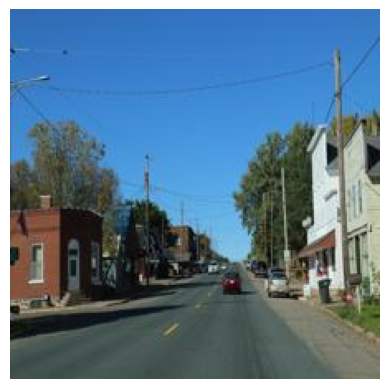

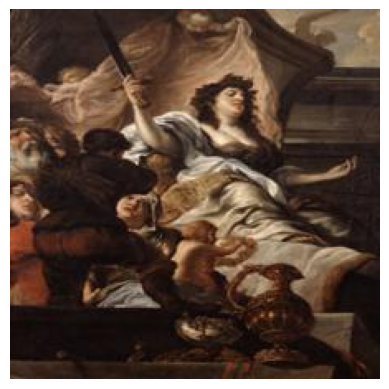

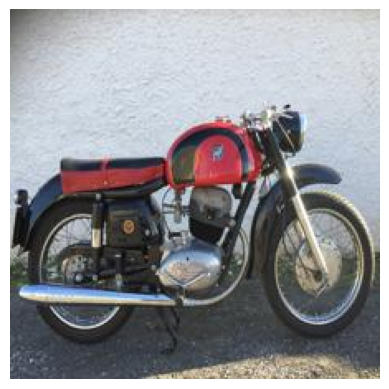

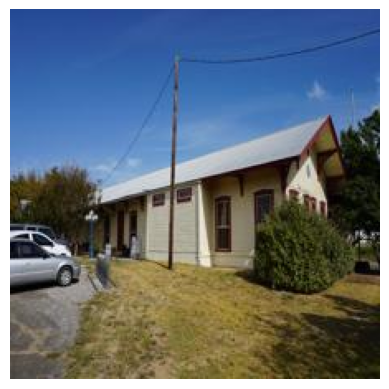

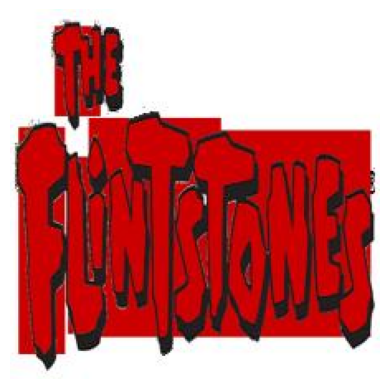

In [ ]:
data_path = 'images_with_paths.csv'
data = pd.read_csv(data_path)

print(data.head())

import matplotlib.pyplot as plt
from PIL import Image

sample_images = data['image_path'].dropna().head(5)

for img_path in sample_images:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
!pip install transformers

In [ ]:
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: ke

### **Extract CLIP Features for Images**

In [ ]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model.to(device)

data_path = 'images_with_paths.csv'
data = pd.read_csv(data_path)
data = data.dropna(subset=['image_path'])

def extract_clip_features(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            features = clip_model.get_image_features(**inputs).cpu().numpy()
        return features.squeeze()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return np.zeros(512)

clip_features = []
for idx, row in tqdm(data.iterrows(), total=len(data), desc="Extracting CLIP features"):
    image_path = row['image_path']
    features = extract_clip_features(image_path)
    clip_features.append(features)

clip_features = np.array(clip_features)
np.save('clip_features.npy', clip_features)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Extracting CLIP features: 100%|██████████| 13919/13919 [54:22<00:00,  4.27it/s]


### **Loading BLIP model**

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPTextModel
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F

# Load BLIP and CLIP models
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
clip_text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
blip_model.train()
clip_text_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
blip_model.to(device)
clip_text_model.to(device)

data = pd.read_csv('images_with_paths.csv')
clip_features = np.load('clip_features.npy')

# Filter out invalid features
data = data.dropna(subset=['image_path'])
valid_features_mask = np.any(clip_features != 0, axis=1)
clip_features = clip_features[valid_features_mask]
data = data[valid_features_mask]

assert len(data) == len(clip_features)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

### **Prepare Dataset for Fine-Tuning BLIP**

In [ ]:
# Dataset class to fine-tune BLIP
class ClipBlipDataset(Dataset):
    def __init__(self, dataframe, clip_features, processor, max_length=128):
        self.dataframe = dataframe
        self.clip_features = clip_features
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']
        caption = self.dataframe.iloc[idx]['cleaned_caption']
        image_feature = torch.tensor(self.clip_features[idx], dtype=torch.float32)

        raw_image = Image.open(image_path).convert("RGB")

        inputs = self.processor(
            images=raw_image,
            text=caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'clip_features': image_feature
        }

dataset = ClipBlipDataset(data, clip_features, blip_processor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

optimizer = AdamW(blip_model.parameters(), lr=5e-5)

### **Fine-Tune BLIP Model**

In [ ]:
epochs = 1
for epoch in range(epochs):
    total_loss = 0.0
    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids = batch['input_ids'][:, :77].to(device)
        attention_mask = batch['attention_mask'][:, :77].to(device)
        pixel_values = batch['pixel_values'].to(device)
        clip_features = batch['clip_features'].to(device)

        # Forward pass using BLIP
        outputs = blip_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            labels=input_ids
        )

        loss = outputs.loss

        with torch.no_grad():
            generated_text_features = clip_text_model(input_ids=input_ids).last_hidden_state.mean(dim=1)

        # Cosine similarity loss between CLIP features and BLIP text features
        cosine_sim_loss = 1 - F.cosine_similarity(generated_text_features, clip_features).mean()

        # Total loss is a combination of cross-entropy loss and cosine similarity loss
        total_batch_loss = loss + cosine_sim_loss

        # Backpropagation
        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()

        total_loss += total_batch_loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss:.4f}")

Training Epoch 1/1: 100%|██████████| 870/870 [1:55:54<00:00,  7.99s/it]

Epoch 1/1, Average Loss: 2.1515


In [ ]:
blip_model.save_pretrained("fine_tuned_blip_model")

In [ ]:
import shutil

save_directory = "fine_tuned_blip_model"

blip_model.save_pretrained(save_directory)

blip_processor.save_pretrained(save_directory)

shutil.make_archive(save_directory, 'zip', save_directory)

'/content/fine_tuned_blip_model.zip'

In [ ]:
import zipfile
import os

zip_file = "fine_tuned_blip_model.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(".")

### **Loading the Fine-Tuned BLIP model**

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

fine_tuned_model_directory = "fine_tuned_blip_model"
blip_model = BlipForConditionalGeneration.from_pretrained(fine_tuned_model_directory)
blip_processor = BlipProcessor.from_pretrained(fine_tuned_model_directory)

blip_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
blip_model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


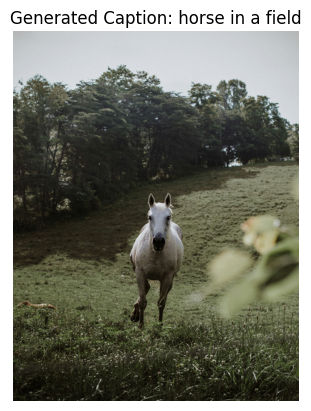

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_fine_tuned_caption(image_path):
    raw_image = Image.open(image_path).convert("RGB")
    inputs = blip_processor(images=raw_image, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = blip_model.generate(**inputs)
    caption = blip_processor.decode(generated_ids[0], skip_special_tokens=True)

    plt.imshow(raw_image)
    plt.axis('off')
    plt.title(f"Generated Caption: {caption}")
    plt.show()

test_image_path = "3.jpg"
generate_fine_tuned_caption(test_image_path)

### **Deployment**

In [ ]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [ ]:
#from huggingface_hub import login
#login()
#login with your secret token 

In [ ]:
!git clone https://huggingface.co/spaces/Wendgan/wikipedia_image_captioning_CLIP_BLIP

Cloning into 'wikipedia_image_captioning_CLIP_BLIP'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (4/4), 1.29 KiB | 1.29 MiB/s, done.


In [ ]:
%cd wikipedia_image_captioning_CLIP_BLIP

/content/wikipedia_image_captioning_CLIP_BLIP


In [ ]:
!cp -r /content/fine_tuned_blip_model/* /content/wikipedia_image_captioning_CLIP_BLIP/

In [ ]:
!echo '

/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [ ]:
with open('app.py', 'w') as f:
    f.write("""
import gradio as gr
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BlipForConditionalGeneration.from_pretrained("./").to(device)
processor = BlipProcessor.from_pretrained("./")

def generate_caption(image):
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        generated_ids = model.generate(**inputs)
    caption = processor.decode(generated_ids[0], skip_special_tokens=True)
    return caption

interface = gr.Interface(fn=generate_caption, inputs="image", outputs="text")
interface.launch()
""")

In [ ]:
!git remote set-url origin https://huggingface.co/Wendgan/wikipedia_image_captioning_CLIP_BLIP

In [ ]:
!pip install huggingface_hub

In [ ]:
!git remote set-url origin https://huggingface.co/spaces/Wendgan/wikipedia_image_captioning_CLIP_BLIP

In [ ]:
%cd /content/wikipedia_image_captioning_CLIP_BLIP

/content/wikipedia_image_captioning_CLIP_BLIP


In [ ]:
with open('requirements.txt', 'w') as f:
    f.write("""
transformers
torch
Pillow
gradio
""")

In [ ]:
!zip -r /content/wikipedia_image_captioning_CLIP_BLIP.zip /content/wikipedia_image_captioning_CLIP_BLIP/

  adding: content/wikipedia_image_captioning_CLIP_BLIP/ (stored 0%)
  adding: content/wikipedia_image_captioning_CLIP_BLIP/.git/ (stored 0%)
  adding: content/wikipedia_image_captioning_CLIP_BLIP/.git/objects/ (stored 0%)
  adding: content/wikipedia_image_captioning_CLIP_BLIP/.git/objects/46/ (stored 0%)
  adding: content/wikipedia_image_captioning_CLIP_BLIP/.git/objects/46/d47aabaf39a55e68bab791cd90c846fcfa5eb3 (stored 0%)
  adding: content/wikipedia_image_captioning_CLIP_BLIP/.git/objects/c9/ (stored 0%)
  adding: content/wikipedia_image_captioning_CLIP_BLIP/.git/objects/c9/677ff38777ee9da8d7b7e474774d1cbd78fd0e (stored 0%)
  adding: content/wikipedia_image_captioning_CLIP_BLIP/.git/objects/c9/6b0887b49b41705ebe3803c45504c48f37fac8 (stored 0%)
  adding: content/wikipedia_image_captioning_CLIP_BLIP/.git/objects/82/ (stored 0%)
  adding: content/wikipedia_image_captioning_CLIP_BLIP/.git/objects/82/d349f23e70a5986eb6f5439131afde64ee2eed (stored 0%)
  adding: content/wikipedia_image_capt

### **Automatic Evaluation**

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import numpy as np

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

def evaluate_captions(generated_captions, reference_captions):
    bleu_scores = []

    for generated, reference in zip(generated_captions, reference_captions):
        reference_tokens = reference.split()
        generated_tokens = generated.split()

        smoothing_fn = SmoothingFunction().method4
        bleu = sentence_bleu([reference_tokens], generated_tokens, smoothing_function=smoothing_fn)
        bleu_scores.append(bleu)

    avg_bleu = np.mean(bleu_scores)

    print(f"Average BLEU Score: {avg_bleu:.4f}")

generated_captions = []
reference_captions = []

test_images_data = data.iloc[:5]

for idx, row in test_images_data.iterrows():
    img_path = row['image_path']
    reference_caption = row['cleaned_caption']

    raw_image = Image.open(img_path).convert("RGB")
    inputs = blip_processor(images=raw_image, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = fine_tuned_blip_model.generate(**inputs)
    generated_caption = blip_processor.decode(generated_ids[0], skip_special_tokens=True)

    generated_captions.append(generated_caption)
    reference_captions.append(reference_caption)

evaluate_captions(generated_captions, reference_captions)

Average BLEU Score: 0.0074


### **Human Evaluation**

In [ ]:
import pandas as pd

data = pd.read_csv('survey.csv')
print(data.columns)

Index(['Timestamp',
       'Relevance: How relevant is the output to the original image? (1-10)  ',
       'Fluency: How fluent and natural is the language used in the output? (1-10)  ',
       'Conciseness: How concise and to the point is the output? (1-10)  ',
       'Detail: How detailed and informative is the output? (1-10)',
       'You can add the image (optional)', 'Column 6'],
      dtype='object')


In [ ]:
data.columns = data.columns.str.strip()

data.rename(columns={
    'Relevance: How relevant is the output to the original image? (1-10)': 'Relevance',
    'Fluency: How fluent and natural is the language used in the output? (1-10)': 'Fluency',
    'Conciseness: How concise and to the point is the output? (1-10)': 'Conciseness',
    'Detail: How detailed and informative is the output? (1-10)': 'Detail'
}, inplace=True)

print(data.columns)

Index(['Timestamp', 'Relevance', 'Fluency', 'Conciseness', 'Detail',
       'You can add the image (optional)', 'Column 6'],
      dtype='object')


Average Relevance Score: 7.29
Standard Deviation for Relevance Score: 2.58

Average Fluency Score: 7.61
Standard Deviation for Fluency Score: 2.30

Average Conciseness Score: 7.55
Standard Deviation for Conciseness Score: 2.57

Average Detail Score: 7.52
Standard Deviation for Detail Score: 2.20



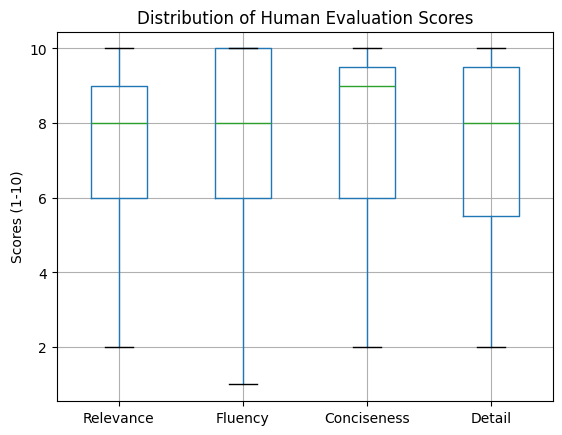

In [ ]:
criteria = ['Relevance', 'Fluency', 'Conciseness', 'Detail']

for criterion in criteria:
    avg_score = data[criterion].mean()
    std_score = data[criterion].std()
    print(f"Average {criterion} Score: {avg_score:.2f}")
    print(f"Standard Deviation for {criterion} Score: {std_score:.2f}")
    print()

# Visualize results
import matplotlib.pyplot as plt

data[criteria].boxplot()
plt.title("Distribution of Human Evaluation Scores")
plt.ylabel("Scores (1-10)")
plt.show()